In [1]:
#Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import typing
from typing import List

In [2]:
# Define transformation to be applied
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(24)], p=0.1),
    transforms.Resize((32, 32)),
    transforms.RandomRotation((-7.0, 7.0), fill=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.49139968, 0.48215827, 0.44653124,), std=(0.24703233, 0.24348505, 0.26158768))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.49139968, 0.48215827, 0.44653124,), std=(0.24703233, 0.24348505, 0.26158768))
])

In [3]:
# Download train and test data
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Run only once initially to get mean and std.
# Data statistics

def compute_mean_std(training_data) -> List[tuple]:
    """
        Compute mean and std of training data. For Cifar10 which has 3 channels in input images.
        Cifar10 is a collection of pair of image (at 0 index) and labels (at 1 index)
    """
    imgs = [item[0] for item in training_data]
    imgs = torch.stack(imgs, dim=0).numpy()     # Stacks all images columnwise and then converts the data to numpy.

    # calculate mean over each channel (r,g,b)
    mean_r = imgs[:,0,:,:].mean()
    mean_g = imgs[:,1,:,:].mean()
    mean_b = imgs[:,2,:,:].mean()


    # calculate std over each channel (r,g,b)
    std_r = imgs[:,0,:,:].std()
    std_g = imgs[:,1,:,:].std()
    std_b = imgs[:,2,:,:].std()

    return [(mean_r,mean_g,mean_b,), (std_r,std_g,std_b,)]


print('[Train]')
print(' - Numpy Shape:', train.data.shape)

mean_, std_ = compute_mean_std(train)
print(' - Mean of 3 channels', mean_)
print(' - Std of 3 channels', std_)


[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Mean of 3 channels (-0.04998368, -0.055006083, -0.048341688)
 - Std of 3 channels (1.0259508, 1.0251788, 1.0128595)


In [5]:
# Set Device, Train Loader, Test Loader
SEED = 1

# Check for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Check for MPS
mps = torch.backends.mps.is_available()
print("MPS Available?", mps)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
elif mps:
    torch.mps.manual_seed(SEED)

device = "cuda" if cuda else "mps" if mps else "cpu"
print("Device = ", device)


CUDA Available? False
MPS Available? True
Device =  mps


In [6]:
# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) \
if cuda or mps else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print('images in batch and shape of an image', images.shape)
print('labels : ', labels.shape)

images in batch and shape of an image torch.Size([128, 3, 32, 32])
labels :  torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'ship')

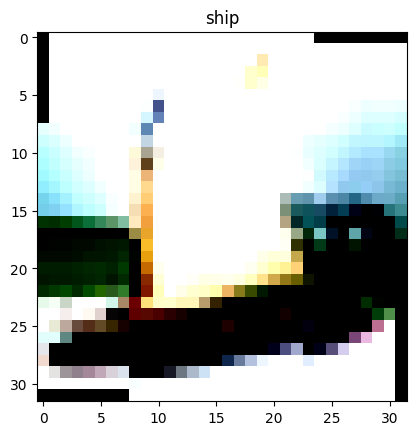

In [8]:
# Visualise 1 image
img = images[0].numpy()           # Shape 3x32x32
img = img.transpose(1,2,0)      # Transpose to 32x32x3 for visualising in plt.imshow
labels_mapping = {idx:cls for cls, idx in train.class_to_idx.items()}
label = labels_mapping[labels[0].item()]

%matplotlib inline
plt.tight_layout()
plt.imshow(img)
plt.title(label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

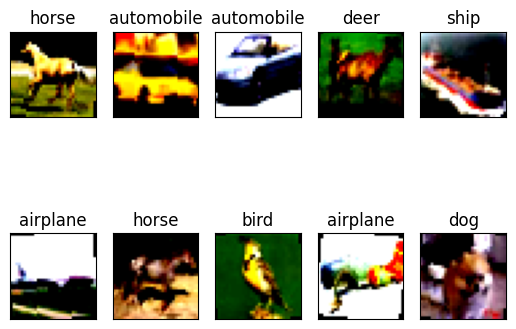

In [9]:
from visualise import return_dataset_images

labels_mapping = {idx:cls for cls, idx in train.class_to_idx.items()}

return_dataset_images(train_loader=train_loader, total_images=10, labels_mapping=labels_mapping)

In [10]:
from model import Cifar10, model_summary
model = Cifar10(device, norm="bn").to(device)
model_summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             528
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,320
             ReLU-12           [-1, 16, 16, 16]               0
      BatchNorm2d-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [11]:
from model import model_train, model_test

path = "trained_model/cifar10.pth"

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss

epochs = 20

for epoch in range(1, epochs+1):
    print("Epoch ", epoch)
    model_train(model, device, train_loader, optimizer, criterion, path)
    model_test(model, device, test_loader, criterion)
    #scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  1


Train: Loss=1.2279 Batch_id=390 Accuracy=45.69: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 1.1973, Accuracy: 5767/10000 (57.67%)

Epoch  2


Train: Loss=1.3228 Batch_id=390 Accuracy=59.80: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 1.0262, Accuracy: 6359/10000 (63.59%)

Epoch  3


Train: Loss=0.9704 Batch_id=390 Accuracy=64.80: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.9656, Accuracy: 6582/10000 (65.82%)

Epoch  4


Train: Loss=0.9671 Batch_id=390 Accuracy=68.23: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]



Test set: Average loss: 0.8489, Accuracy: 7061/10000 (70.61%)

Epoch  5


Train: Loss=0.7885 Batch_id=390 Accuracy=70.73: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.7980, Accuracy: 7270/10000 (72.70%)

Epoch  6


Train: Loss=0.5972 Batch_id=390 Accuracy=71.92: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 0.7253, Accuracy: 7480/10000 (74.80%)

Epoch  7


Train: Loss=0.6575 Batch_id=390 Accuracy=73.40: 100%|██████████| 391/391 [01:21<00:00,  4.78it/s]



Test set: Average loss: 0.6877, Accuracy: 7662/10000 (76.62%)

Epoch  8


Train: Loss=0.6782 Batch_id=390 Accuracy=74.38: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]



Test set: Average loss: 0.6737, Accuracy: 7670/10000 (76.70%)

Epoch  9


Train: Loss=0.8042 Batch_id=390 Accuracy=75.37: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]



Test set: Average loss: 0.6647, Accuracy: 7704/10000 (77.04%)

Epoch  10


Train: Loss=0.5848 Batch_id=390 Accuracy=75.74: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.6568, Accuracy: 7717/10000 (77.17%)

Epoch  11


Train: Loss=0.6555 Batch_id=390 Accuracy=76.45: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.6363, Accuracy: 7808/10000 (78.08%)

Epoch  12


Train: Loss=0.7051 Batch_id=390 Accuracy=76.88: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]



Test set: Average loss: 0.6455, Accuracy: 7770/10000 (77.70%)

Epoch  13


Train: Loss=0.6345 Batch_id=390 Accuracy=77.37: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 0.6317, Accuracy: 7830/10000 (78.30%)

Epoch  14


Train: Loss=0.5951 Batch_id=390 Accuracy=78.08: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.6156, Accuracy: 7876/10000 (78.76%)

Epoch  15


Train: Loss=0.6478 Batch_id=390 Accuracy=78.15: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s]



Test set: Average loss: 0.5987, Accuracy: 7951/10000 (79.51%)

Epoch  16


Train: Loss=0.7464 Batch_id=390 Accuracy=78.60: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]



Test set: Average loss: 0.6018, Accuracy: 7942/10000 (79.42%)

Epoch  17


Train: Loss=0.6781 Batch_id=390 Accuracy=78.66: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.5985, Accuracy: 7950/10000 (79.50%)

Epoch  18


Train: Loss=0.7756 Batch_id=390 Accuracy=79.12: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 0.6042, Accuracy: 7929/10000 (79.29%)

Epoch  19


Train: Loss=0.8542 Batch_id=390 Accuracy=78.97: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]



Test set: Average loss: 0.5972, Accuracy: 7937/10000 (79.37%)

Epoch  20


Train: Loss=0.7346 Batch_id=390 Accuracy=79.54: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]



Test set: Average loss: 0.5866, Accuracy: 8015/10000 (80.15%)



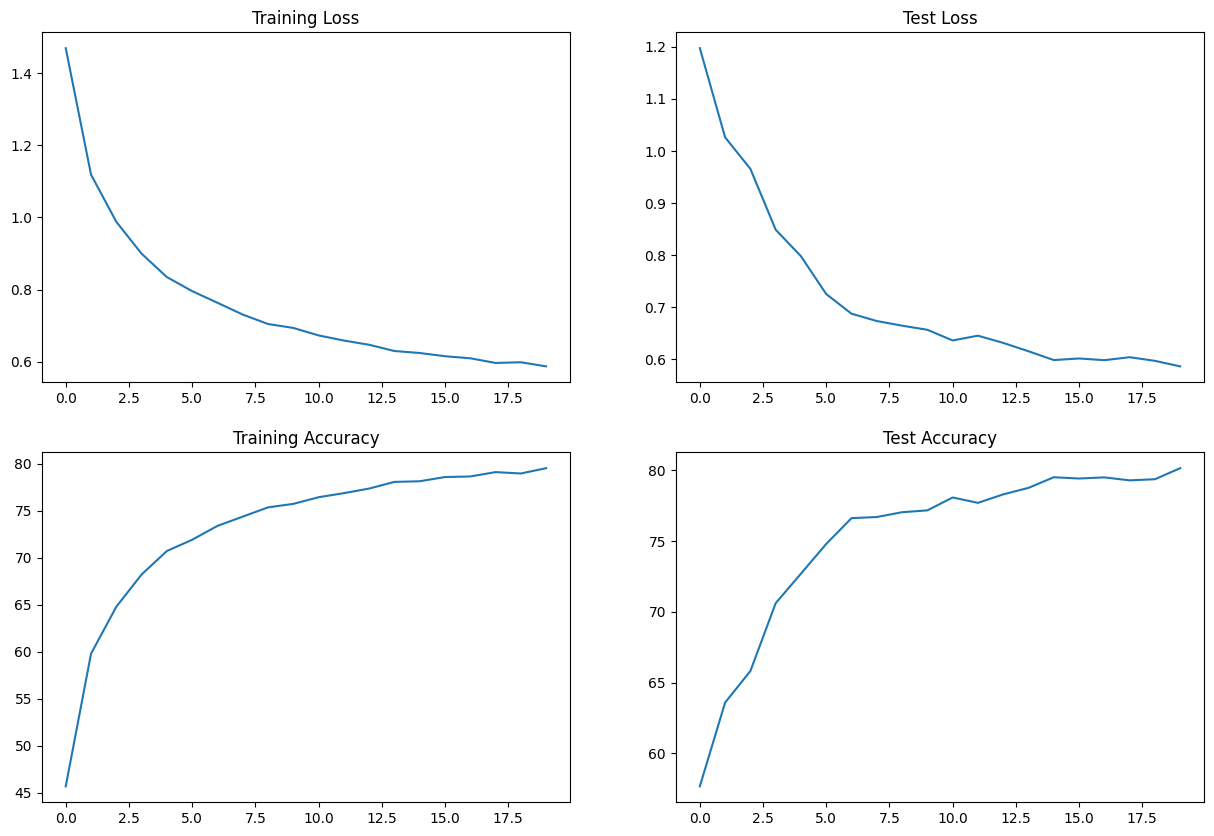

In [12]:
from visualise import draw_graphs
draw_graphs()

In [13]:
from utils import get_incorrrect_predictions, load_weights_from_path

model = load_weights_from_path(model, "trained_model/cifar10.pth")

incorrect = get_incorrrect_predictions(model, test_loader, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total Incorrect Predictions 1985


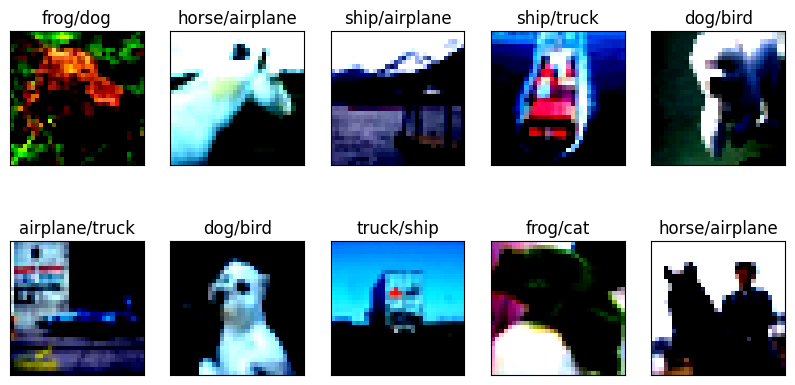

In [14]:
from visualise import plot_incorrect_predictions
plot_incorrect_predictions(incorrect, labels_mapping, 10)